# Mount Drive & Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import mahotas

import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Path & Class Check

In [ ]:
DATASET_PATH = "/content/drive/MyDrive/tomato/train"

classes = sorted(os.listdir(DATASET_PATH))
print("Classes:", classes)

Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# Load Images Once (NO FEATURE YET)

In [ ]:
images = []
labels = []

for label in classes:
    folder = os.path.join(DATASET_PATH, label)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (128, 128))

        images.append(gray)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

print("Total images:", len(images))


Total images: 10149


# Encode Labels

In [ ]:
le = LabelEncoder()
y = le.fit_transform(labels)

print("Encoded classes:", le.classes_)


Encoded classes: ['Tomato___Bacterial_spot' 'Tomato___Early_blight' 'Tomato___Late_blight'
 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus'
 'Tomato___healthy']


# Feature Extraction Functions

In [ ]:
def extract_haralick(images):
    feats = []
    for img in images:
        feats.append(mahotas.features.haralick(img.astype(np.uint8)).mean(axis=0))
    return np.array(feats)


def extract_hog(images):
    feats = []
    for img in images:
        feats.append(
            hog(
                img,
                orientations=9,
                pixels_per_cell=(16, 16),
                cells_per_block=(2, 2),
                block_norm="L2-Hys",
                transform_sqrt=True
            )
        )
    return np.array(feats)


def extract_combined(images):
    har = extract_haralick(images)
    hogf = extract_hog(images)
    return np.concatenate([har, hogf], axis=1)


# Prepare Feature Sets

In [ ]:
X_haralick = extract_haralick(images)
X_hog = extract_hog(images)
X_combined = extract_combined(images)

print("Haralick shape:", X_haralick.shape)
print("HOG shape:", X_hog.shape)
print("Combined shape:", X_combined.shape)



Haralick shape: (10149, 13)
HOG shape: (10149, 1764)
Combined shape: (10149, 1777)


# Models & 5-Fold CV Function

In [ ]:
models = {
    "SVM": SVC(kernel="rbf", C=10, gamma="scale"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)


def run_cv(X, y, name):
    print(f"\n===== {name} FEATURES =====")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    results = {}
    for model_name, model in models.items():
        scores = cross_val_score(model, X_scaled, y, cv=kf)
        results[model_name] = scores
        print(f"{model_name}")
        print("  Mean:", scores.mean())
        print("  Std :", scores.std())
    return results


# Cross-Validation Accuracy Extractor

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def get_cv_mean_accuracy(X, y, model):
    """
    Returns mean 5-fold CV accuracy for a given feature matrix and model.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    scores = cross_val_score(
        model,
        X_scaled,
        y,
        cv=skf,
        scoring="accuracy"
    )
    return scores.mean()


This section was introduced to standardize model evaluation and ensure a fair, unbiased comparison between different feature extraction methods and machine learning models.

Rather than relying on a single train–test split—which can lead to unstable or misleading performance estimates—the study employs 5-fold stratified cross-validation. This approach allows each sample to be used for both training and validation across multiple folds, resulting in a more reliable estimate of model performance.

this step is necessary because -

Reduces evaluation bias caused by arbitrary data splits

Improves result stability by averaging performance across multiple folds

Ensures fair comparison between:

Feature sets (Haralick, HOG, Haralick + HOG)

Classifiers (SVM, Random Forest, KNN)

Prevents over-interpretation of unusually good or bad single-split results

Cross-validation is especially important in agricultural image datasets, where:

Class distributions may be imbalanced

Visual patterns between diseases are highly similar

Dataset size varies significantly across crops

The cross-validation extraction function:

Applies feature scaling to ensure numerical stability, particularly for SVM and KNN

Performs 5-fold stratified cross-validation, preserving class proportions in each fold

Computes accuracy for each fold

Returns the mean accuracy, which serves as the final performance metric

This produces a single, statistically meaningful scalar value per model–feature combination, enabling clean aggregation and visualization across datasets.

For comparative analysis and plotting, mean cross-validation accuracy was selected because it:

Represents the model’s expected performance on unseen data

Allows consistent aggregation across different datasets

Avoids cherry-picking best-case folds

Is widely accepted in peer-reviewed machine learning literature

Additional metrics such as confusion matrices and per-class scores are analyzed separately for diagnostic purposes, but are not used for high-level model comparison.

# RUN 5-FOLD CV

In [ ]:
cv_haralick = run_cv(X_haralick, y, "HARALICK")
cv_hog = run_cv(X_hog, y, "HOG")
cv_combined = run_cv(X_combined, y, "HARALICK + HOG")



===== HARALICK FEATURES =====
SVM
  Mean: 0.6477480959583575
  Std : 0.008813535418554772
Random Forest
  Mean: 0.6627250192407141
  Std : 0.0039058831196694013
KNN
  Mean: 0.5882342001568392
  Std : 0.006637347137817813

===== HOG FEATURES =====
SVM
  Mean: 0.745099748231918
  Std : 0.010024179606402913
Random Forest
  Mean: 0.6144443014710346
  Std : 0.00703816701133241
KNN
  Mean: 0.5423188884329925
  Std : 0.003881097671814401

===== HARALICK + HOG FEATURES =====
SVM
  Mean: 0.7786000043701305
  Std : 0.008952541199750216
Random Forest
  Mean: 0.71839625916817
  Std : 0.01051706643311374
KNN
  Mean: 0.561533090386441
  Std : 0.0021248896817637093


# Bar Plot (CV-Based, Correct)

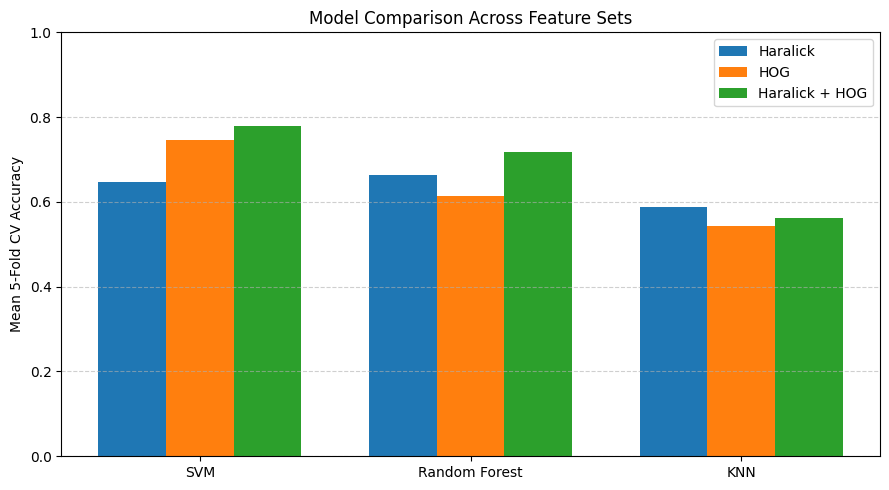

In [ ]:
results = {
    "Haralick": {
        m: np.mean(cv_haralick[m]) for m in models
    },
    "HOG": {
        m: np.mean(cv_hog[m]) for m in models
    },
    "Haralick + HOG": {
        m: np.mean(cv_combined[m]) for m in models
    }
}

models_list = list(models.keys())
features = list(results.keys())

x = np.arange(len(models_list))
width = 0.25

plt.figure(figsize=(9,5))

for i, feat in enumerate(features):
    plt.bar(x + i*width,
            [results[feat][m] for m in models_list],
            width,
            label=feat)

plt.xticks(x + width, models_list)
plt.ylabel("Mean 5-Fold CV Accuracy")
plt.title("Model Comparison Across Feature Sets")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Final Model (Confusion Matrix)

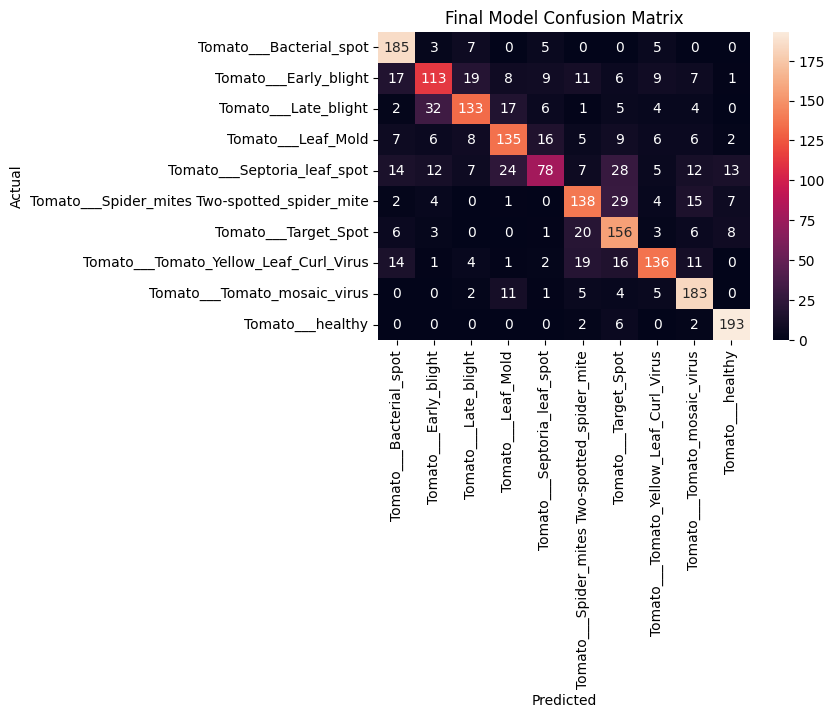

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.75      0.90      0.82       205
                        Tomato___Early_blight       0.65      0.56      0.60       200
                         Tomato___Late_blight       0.74      0.65      0.69       204
                           Tomato___Leaf_Mold       0.69      0.68      0.68       200
                  Tomato___Septoria_leaf_spot       0.66      0.39      0.49       200
Tomato___Spider_mites Two-spotted_spider_mite       0.66      0.69      0.68       200
                         Tomato___Target_Spot       0.60      0.77      0.68       203
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.77      0.67      0.71       204
                 Tomato___Tomato_mosaic_virus       0.74      0.87      0.80       211
                             Tomato___healthy       0.86      0.95      0.90       203

                                     accu

In [ ]:
X_final = X_combined
scaler = StandardScaler()
X_final = scaler.fit_transform(X_final)

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, stratify=y, random_state=42
)

final_model = RandomForestClassifier(n_estimators=200, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Final Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_pred, target_names=le.classes_))


# Extract CV Results

In [ ]:
results_tomato = {
    "Haralick": {},
    "HOG": {},
    "Haralick + HOG": {}
}

for model_name, model in models.items():
    results_tomato["Haralick"][model_name] = get_cv_mean_accuracy(
        X_haralick, y, model
    )

    results_tomato["HOG"][model_name] = get_cv_mean_accuracy(
        X_hog, y, model
    )

    results_tomato["Haralick + HOG"][model_name] = get_cv_mean_accuracy(
        X_combined, y, model
    )

print("Tomato CV Results:")
results_tomato


Tomato CV Results:


{'Haralick': {'SVM': np.float64(0.6476487968787555),
  'Random Forest': np.float64(0.668635572377861),
  'KNN': np.float64(0.5947373915661334)},
 'HOG': {'SVM': np.float64(0.7442114463432932),
  'Random Forest': np.float64(0.6134603422783433),
  'KNN': np.float64(0.5433045956779409)},
 'Haralick + HOG': {'SVM': np.float64(0.7805691366806915),
  'Random Forest': np.float64(0.7203669938599664),
  'KNN': np.float64(0.5593656998157261)}}

# Quick check

In [ ]:
for feature, vals in results_tomato.items():
    print(f"\n{feature}")
    for model, acc in vals.items():
        print(f"  {model}: {acc:.3f}")



Haralick
  SVM: 0.648
  Random Forest: 0.669
  KNN: 0.595

HOG
  SVM: 0.744
  Random Forest: 0.613
  KNN: 0.543

Haralick + HOG
  SVM: 0.781
  Random Forest: 0.720
  KNN: 0.559


# Saving data

In [ ]:
import json

with open("results_tomato.json", "w") as f:
    json.dump(results_tomato, f)

!cp results_tomato.json /content/drive/MyDrive/


In [ ]:
np.save("X_tomato_combined.npy", X_combined)
np.save("y_tomato.npy", y)

# Copy to Google Drive for persistence
!cp X_tomato_combined.npy /content/drive/MyDrive/
!cp y_tomato.npy /content/drive/MyDrive/

print("Tomato feature matrices saved to Drive")

Tomato feature matrices saved to Drive
